In [32]:
#import libraries
import boto3
from sagemaker import get_execution_role

import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse import hstack
import re, nltk
nltk.download('stopwords')
nltk.download('punkt')
stopwords = set(nltk.corpus.stopwords.words('english'))
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD,  NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
#connect to S3
bucket='bbc-kb789'
conn = boto3.client('s3')


In [3]:
#access csv file with dataset on s3
bucket='dbpedia-kb789'
data_key = 'DBP_wiki_data.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

db_file=pd.read_csv(data_location)
db_file.head()

,text,l1,l2,l3,wiki_name,word_count
0,The 1994 Mindoro earthquake occurred on Novemb...,Event,NaturalEvent,Earthquake,1994_Mindoro_earthquake,59
1,The 1917 Bali earthquake occurred at 06:50 loc...,Event,NaturalEvent,Earthquake,1917_Bali_earthquake,68
2,The 1941 Colima earthquake occurred on April 1...,Event,NaturalEvent,Earthquake,1941_Colima_earthquake,194
3,The 1983 Coalinga earthquake occurred on May 2...,Event,NaturalEvent,Earthquake,1983_Coalinga_earthquake,98
4,The 2013 Bushehr earthquake occurred with a mo...,Event,NaturalEvent,Earthquake,2013_Bushehr_earthquake,61


In [4]:
# drop columns not being used
db_file=db_file.drop(['l1', 'l2', 'wiki_name', 'word_count'], axis=1)

In [5]:
#rename columns and display first 5 rows
db_file.columns = ['Document', 'Category']
db_file.head()

,Document,Category
0,The 1994 Mindoro earthquake occurred on Novemb...,Earthquake
1,The 1917 Bali earthquake occurred at 06:50 loc...,Earthquake
2,The 1941 Colima earthquake occurred on April 1...,Earthquake
3,The 1983 Coalinga earthquake occurred on May 2...,Earthquake
4,The 2013 Bushehr earthquake occurred with a mo...,Earthquake


In [6]:
#Check if there are any articles that don't have labels
db_file['Category'].isnull().values.any()

False

In [7]:
#data exploration
db_file.describe(include=['object'])

,Document,Category
count,342781,342781
unique,342781,219
top,Lemon Souffle (22 February 1991–8 October 2001...,Planet
freq,1,2700


In [8]:
#explore how many times each label is used. 
db_file['Category'].value_counts(ascending=True)

BiologicalDatabase        187
CanadianFootballTeam      190
BeachVolleyballPlayer     194
AnimangaCharacter         203
Cycad                     204
                         ... 
FootballMatch            2700
AcademicJournal          2700
Manga                    2700
GolfPlayer               2700
Planet                   2700
Name: Category, Length: 219, dtype: int64

<AxesSubplot:>

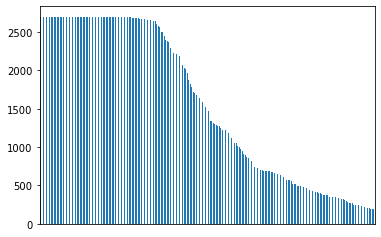

In [9]:
#data visualization: range of the number of times each label is used.
db_file['Category'].value_counts(sort=True).plot.bar(xticks=[])



In [10]:
#get average length of articles
result = pd.DataFrame([[]])
result = db_file['Document'].apply(len).mean()
print(result)


643.295337256149


In [11]:
#convert unpreprocessed text to numeric format
tfidf_i = TfidfVectorizer()
df_tf_i =  tfidf_i.fit_transform(db_file['Document'])

In [12]:
#convert unpreprocessed text to numeric format
cv_i= CountVectorizer()
df_cv_i= cv_i.fit_transform(db_file['Document']) 

In [13]:
#set initial x to documents
init_x=df_tf_i 

In [14]:
#set inital y to labels
init_y=db_file['Category']

In [15]:
#split dataset into train, text values
x_itrain, x_itest, y_itrain, y_itest = train_test_split(init_x, init_y, random_state=4)

In [16]:
#Create a Gaussian Classifier as benchmark model. 
clf_init=RandomForestClassifier(max_depth=5)

#Train the model using the training sets 
clf_init.fit(x_itrain,y_itrain)

#test model with test set
ipredicted_categories=clf_init.predict(x_itest)

In [17]:
#test accuracy of benchmark model
accuracy_score(y_itest, ipredicted_categories)

0.477781926811053

In [18]:
def normalize_document(doc):
    """
    inputs document
    outputs text cleaned document
    """
    #lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    
    # tokenize document
    word_tokens = word_tokenize(doc)
    
    # filter stopwords out of document
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stopwords: 
            filtered_sentence.append(w) 
    # re-create document from filtered tokens
    doc = ' '.join(filtered_sentence)
    
    return doc

#SOURCE OF CODE: https://towardsdatascience.com/text-preprocessing-with-nltk-9de5de891658

In [19]:
#normalize document
norm_doc = db_file['Document'].apply(normalize_document)

In [20]:
#display first 5 rows of normalized documents
norm_doc.head()

0    mindoro earthquake occurred november local tim...
1    bali earthquake occurred local time january ja...
2    colima earthquake occurred april utc local tim...
3    coalinga earthquake occurred may exactly utc c...
4    bushehr earthquake occurred moment magnitude a...
Name: Document, dtype: object

In [24]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    """
    inputs nltk pos tag
    outputs wordnet pos tag
    """
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

#initialze lemmatizer
lemmatizer = WordNetLemmatizer()

#SOURCE OF CODE: https://gaurav5430.medium.com/using-nltk-for-lemmatizing-sentences-c1bfff963258

In [27]:
def lemmatize_sentence(sentence):
    """
    inputs sentence
    outputs lemmatized sentence
    """
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

#SOURCE OF CODE: https://gaurav5430.medium.com/using-nltk-for-lemmatizing-sentences-c1bfff963258

In [33]:
#lemmatize document
lemm_doc= norm_doc.apply(lemmatize_sentence)

In [50]:
#check lemmatized document
lemm_doc.head()

0    mindoro earthquake occur november local time n...
1    bali earthquake occur local time january janua...
2    colima earthquake occur april utc local time e...
3    coalinga earthquake occur may exactly utc coal...
4    bushehr earthquake occur moment magnitude apri...
Name: Document, dtype: object

In [87]:
#convert normalized, lemmatized text to numeric format
cv_lemm = CountVectorizer()
cv_lemm_df = cv_lemm.fit_transform(lemm_doc) 

In [72]:
#convert normalized, lemmatized text to numeric format
tdif_lem = TfidfVectorizer()
tdif_lem_df =  tdif_lem.fit_transform(lemm_doc)

In [73]:
#set x to normalized, lemmatized documents
lem_x=tdif_lem_df

In [74]:
# set y to categories
lem_y=db_file['Category']

In [75]:
#split normalized, lemmatized dataset into train, text values
x_ntrain, x_ntest, y_ntrain, y_ntest = train_test_split(lem_x, lem_y, random_state=4)

In [76]:
#Create a Gaussian Classifier as a model
clfnorm=RandomForestClassifier(max_depth=5)

#fit the normalized,lemmatized training data to the model
clfnorm.fit(x_ntrain, y_ntrain)

#test the normalized,lemmatized test data on the model
npredicted_categories = clfnorm.predict(x_ntest)


In [77]:
#find accuracy of model trained on normalized, lemmatized documents
accuracy_score(y_ntest, npredicted_categories)

0.4789255041075429

In [78]:
#fit normalized, lemmatized document corpus to svd to get topics
svd = TruncatedSVD(n_components=60, random_state=42)
svd.fit(tdif_lem_df)

TruncatedSVD(n_components=60, random_state=42)

In [79]:
#transform normalized, lemmatized document corpus to svd
x_svd=svd.transform(tdif_lem_df)

In [80]:
#print topics found by svd
terms = tdif_lem.get_feature_names()

for i, comp in enumerate(svd.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")
        
#SOURCE OF CODE: #https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/ 

Topic 0: 
season
 
football
 
play
 
league
 
team
 
club
 
championship
 
Topic 1: 
football
 
league
 
season
 
team
 
play
 
club
 
coach
 
Topic 2: 
album
 
release
 
single
 
song
 
band
 
record
 
championship
 
Topic 3: 
album
 
football
 
release
 
league
 
season
 
song
 
record
 
Topic 4: 
party
 
election
 
state
 
university
 
serve
 
bear
 
american
 
Topic 5: 
race
 
stake
 
season
 
horse
 
thoroughbred
 
run
 
prix
 
Topic 6: 
specie
 
family
 
habitat
 
tropical
 
subtropical
 
genus
 
moist
 
Topic 7: 
coach
 
university
 
school
 
college
 
head
 
basketball
 
football
 
Topic 8: 
play
 
professional
 
hockey
 
tour
 
station
 
school
 
player
 
Topic 9: 
station
 
football
 
line
 
party
 
radio
 
railway
 
broadcast
 
Topic 10: 
hockey
 
ice
 
station
 
league
 
team
 
season
 
party
 
Topic 11: 
church
 
diocese
 
catholic
 
hockey
 
roman
 
bishop
 
league
 
Topic 12: 
football
 
race
 
australian
 
bear
 
rugby
 
footballer
 
former
 
Topic 13: 
rugby
 
school
 

In [81]:
#fit normalized, lemmatized document corpus to nmf to get topics
model = NMF(n_components=60, random_state=1,alpha=.1, l1_ratio=.5)
model.fit(tdif_lem_df)


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


NMF(alpha=0.1, l1_ratio=0.5, n_components=60, random_state=1)

In [82]:
#transform normalized, lemmatized document corpus to nmf
x_nmf=model.transform(tdif_lem_df)

In [83]:
#print topics found by nmf
n_top_words = 7
feature_names = tdif_lem.get_feature_names()

for topic_idx, topic in enumerate(model.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
#SOURCE OF CODE: https://scikit-learn.org/0.15/auto_examples/applications/topics_extraction_with_nmf.html      

Topic #0:
team handball national womens uci member cycling

Topic #1:
new york zealand jersey city wale hampshire

Topic #2:
album release single song band chart studio

Topic #3:
championship world artistic gymnastics gymnast rhythmic nation

Topic #4:
mountain range peak glacier pas ft locate

Topic #5:
race stake horse thoroughbred run distance racehorse

Topic #6:
genus specie family spider find bromeliad cultivar

Topic #7:
party election seat vote political democratic liberal

Topic #8:
season finish th playoff division win first

Topic #9:
tour golf pga golfer professional play open

Topic #10:
hockey ice play junior nhl canadian ontario

Topic #11:
diocese catholic roman bishop latin archdiocese ecclesiastical

Topic #12:
football nfl play college draft club american

Topic #13:
first character year song also one time

Topic #14:
state court united supreme us case judge

Topic #15:
station radio broadcast fm format license own

Topic #16:
bridge span carry traffic cross road bu

In [88]:
#fit normalized, lemmatized document corpus to lda to get topics
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components = 60, random_state = 42, max_iter=5)
lda.fit(cv_lemm_df)

LatentDirichletAllocation(max_iter=5, n_components=60, random_state=42)

In [89]:
#print topics found by lda
for index, topic in enumerate(lda.components_):
    print(f'Top 7 words for Topic #{index}')
    print([cv_lemm.get_feature_names()[i] for i in topic.argsort()[-7:]])
    print('\n')
#SOURCE OF CODE: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

Top 7 words for Topic #0
['khan', 'christian', 'greek', 'one', 'orthodox', 'know', 'saint']


Top 7 words for Topic #1
['player', 'hockey', 'team', 'game', 'season', 'play', 'league']


Top 7 words for Topic #2
['player', 'record', 'video', 'first', 'version', 'release', 'game']


Top 7 words for Topic #3
['hill', 'line', 'seoul', 'korean', 'south', 'korea', 'station']


Top 7 words for Topic #4
['spider', 'name', 'know', 'find', 'family', 'genus', 'specie']


Top 7 words for Topic #5
['cross', 'license', 'radio', 'format', 'fm', 'earthquake', 'station']


Top 7 words for Topic #6
['art', 'award', 'international', 'event', 'hold', 'film', 'festival']


Top 7 words for Topic #7
['flow', 'power', 'reservoir', 'water', 'lake', 'dam', 'river']


Top 7 words for Topic #8
['serve', 'carolina', 'congress', 'march', 'iowa', 'maine', 'south']


Top 7 words for Topic #9
['mi', 'province', 'martial', 'population', 'also', 'district', 'village']


Top 7 words for Topic #10
['law', 'judge', 'court'

In [90]:
#transform normalized, lemmatized document corpus to lda
x_lda=lda.transform(cv_lemm_df)

In [91]:
#convert lda features to sparse matrix  
sLDA = sparse.csr_matrix(x_lda)

In [92]:
#convert nmf features to sparse matrix 
sNMF = sparse.csr_matrix(x_nmf)

In [93]:
#convert svd features to sparse matrix 
sSVD = sparse.csr_matrix(x_svd)

In [94]:
#Stacks the 4 sparse matrices horizontally into COO matrix
x=hstack((tdif_lem_df, sLDA, sNMF, sSVD))

In [95]:
#Converts COO matrix to CSR matrix, which is X value to be loaded into classifier
x=sparse.csr_matrix(x)

In [96]:
#sets y value equal to article labels
y=db_file['Category']

In [97]:
#split normalized, lemmatized dataset with svd, nmf, and lda features and labels into train, text values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=4)


In [98]:
#Create a Gaussian Classifier with max depth of 5
clf=RandomForestClassifier(max_depth=5)

#Train the model using the training sets 
clf.fit(x_train,y_train)

#Find the predicted labels for the test set
y_pred=clf.predict(x_test)

In [99]:
#print accuracy score of the predicted labels
accuracy_score(y_test, y_pred)

0.559267643764003

In [100]:
#Create final Gaussian Classifier
clf=RandomForestClassifier(max_depth=50, n_estimators=150)

#Train the model using the training sets 
clf.fit(x_train,y_train)

#Find the predicted labels for the test set
y_pred=clf.predict(x_test)

In [101]:
#print accuracy score of the predicted labels
accuracy_score(y_test, y_pred)

0.8417662434652726

In [116]:
def predictArticle(text):
    """
    inputs article not in train/test corpus
    outputs predicted topic label of article
    """
    #normalizes article
    text=normalize_document(text)
    #lemmatizes article
    text=lemmatize_sentence(text)
    #converts article to numeric data using count vectorizer
    X = cv_lemm.transform([text])
    #gets lda features of article
    lda_text=lda.transform(X)
    #converts article to numeric data using TF-IDF Vectorizer
    X = tdif_lem.transform([text])
    #gets nmf features of article
    nmf_text=model.transform(X)
    #gets svd features of article
    svd_text=svd.transform(X)
    #convert to csr matrices
    sLDA_text = sparse.csr_matrix(lda_text)
    sNMF_text = sparse.csr_matrix(nmf_text)
    sSVD_text = sparse.csr_matrix(svd_text)
    #converts article to numeric data using TF-IDF Vectorizer
    x_text=tdif_lem.transform([text])
    #Stacks the 4 sparse matrices horizontally into COO matrix
    x_text=hstack((x_text, sLDA_text, sNMF_text, sSVD_text))
    #Converts COO matrix to CSR matrix, which is X value to be loaded into classifier
    text_matrix=sparse.csr_matrix(x_text)
    #returns model's predicted label for article
    return clf.predict(text_matrix)
    


In [117]:
text=['''
The Beatles broke up five decades ago, but you would never know it from looking at the charts. In late September the group reissued the 50th anniversary edition of its 1969 album "Abbey Road," which hit No. 3 on the Billboard 200 in the U.S. and the top spot in the U.K. The deluxe reissue features a remixed version of the original album and also includes two discs' worth of previously unheard material, a 5.1 surround-sound mix on Blu-ray, and a 100-page hardcover book. At a price just under $100, it's easy to see why someone would be tempted to buy it, even if they already own the original version of the album. The physical media sales are only part of the story. Billboard noted that to reach the No. 3 spot, the group had sold 81,000 physical albums, but according to Forbes, the group’s music has been streamed on Spotify 1.7 billion times in 2019. The group doing 30% of that streaming is between the ages of 18 and 24, followed by 25- to 29-year-olds, at 17%. That means almost half of the streaming is coming from people under the age of 30.
''']
text = ' '.join(text)
print(predictArticle(text))
#Source of article: https://www.cnbc.com/2019/10/26/the-beatles-remain-a-pop-culture-phenomenon-even-among-gen-z-fans.html

['Album']


In [118]:
text2 = ["""
Nile River, Arabic Baḥr Al-Nīl or Nahr Al-Nīl, the longest river in the world, called the father of African rivers. It rises south of the Equator and flows northward through northeastern Africa to drain into the Mediterranean Sea. It has a length of about 4,132 miles (6,650 kilometres) and drains an area estimated at 1,293,000 square miles (3,349,000 square kilometres). Its basin includes parts of Tanzania, Burundi, Rwanda, the Democratic Republic of the Congo, Kenya, Uganda, South Sudan, Ethiopia, Sudan, and the cultivated part of Egypt. Its most distant source is the Kagera River in Burundi. The Nile is formed by three principal streams: the Blue Nile (Arabic: Al-Baḥr Al-Azraq; Amharic: Abay) and the Atbara (Arabic: Nahr ʿAṭbarah), which flow from the highlands of Ethiopia, and the White Nile (Arabic: Al-Baḥr Al-Abyad), the headstreams of which flow into Lakes Victoria and Albert.
"""]
text2 = ' '.join(text2)
print(predictArticle(text2))
#Source of article: https://www.britannica.com/place/Nile-River

['River']


In [119]:
text3 = ["""
Tiger (Eldrick) Woods, born December 30, 1975, is a professional golfer and entrepreneur. Since turning professional in 1996, Tiger has built an unprecedented competitive career. His achievements on the course–106 worldwide wins and 15 majors–have mirrored his success off the course as well. Woods serves as Founder and CEO of TGR, a multibrand enterprise comprised of his various companies and philanthropic endeavors, including TGR Design, the golf course design company; The TGR Foundation, a charitable foundation; TGR Live, an events production company; and The Woods Jupiter, an upscale sports restaurant. He has 82 PGA TOUR wins, tied with Sam Snead, holding the record for most wins in history. His majors victories include the five Masters Tournaments, four PGA Championships, three U.S. Open Championships, and three British Open Championships. With his second Masters victory in 2001, Tiger became the first golfer ever to hold all four professional major championships at the same time.
"""]
text3 = ' '.join(text3)
print(predictArticle(text3))
#Source of article: https://tigerwoods.com/biography/

['GolfPlayer']


In [120]:
text4 = ["""
Saturn is the sixth planet from the Sun and the second largest planet in our solar system. Adorned with a dazzling system of icy rings, Saturn is unique among the planets. It is not the only planet to have rings, but none are as spectacular or as complex as Saturn's. Like fellow gas giant Jupiter, Saturn is a massive ball made mostly of hydrogen and helium. Surrounded by more than 60 known moons, Saturn is home to some of the most fascinating landscapes in our solar system. From the jets of water that spray from Enceladus to the methane lakes on smoggy Titan, the Saturn system is a rich source of scientific discovery and still holds many mysteries. The farthest planet from Earth discovered by the unaided human eye, Saturn has been known since ancient times. The planet is named for the Roman god of agriculture and wealth, who was also the father of Jupiter. With a radius of 36,183.7 miles (58,232 kilometers), Saturn is 9 times wider than Earth. If Earth were the size of a nickel, Saturn would be about as big as a volleyball. From an average distance of 886 million miles (1.4 billion kilometers), Saturn is 9.5 astronomical units away from the Sun. One astronomical unit (abbreviated as AU), is the distance from the Sun to Earth. From this distance, it takes sunlight 80 minutes to travel from the Sun to Saturn. Saturn has the second-shortest day in the solar system. One day on Saturn takes only 10.7 hours (the time it takes for Saturn to rotate or spin around once), and Saturn makes a complete orbit around the Sun (a year in Saturnian time) in about 29.4 Earth years (10,756 Earth days). Its axis is tilted by 26.73 degrees with respect to its orbit around the Sun, which is similar to Earth's 23.5-degree tilt. This means that, like Earth, Saturn experiences seasons. Like Jupiter, Saturn is made mostly of hydrogen and helium. At Saturn's center is a dense core of metals like iron and nickel surrounded by rocky material and other compounds solidified by the intense pressure and heat. It is enveloped by liquid metallic hydrogen inside a layer of liquid hydrogen—similar to Jupiter's core but considerably smaller. It's hard to imagine, but Saturn is the only planet in our solar system whose average density is less than water. The giant gas planet could float in a bathtub if such a colossal thing existed. Saturn took shape when the rest of the solar system formed about 4.5 billion years ago, when gravity pulled swirling gas and dust in to become this gas giant. About 4 billion years ago, Saturn settled into its current position in the outer solar system, where it is the sixth planet from the Sun. Like Jupiter, Saturn is mostly made of hydrogen and helium, the same two main components that make up the Sun.
"""]
text4 = ' '.join(text4)
print(predictArticle(text4))
#Source of article: https://solarsystem.nasa.gov/planets/saturn/in-depth/

['Planet']
